# Clasificacion de Generos Musicales

Este cuaderno se divide en tres partes:


   1) Usando red neuronal artificial (ANN)

   2) Abordar el sobreajuste con ANN

   3) Usando CNN


El dataset contiene la siguiente clasificacion de generos:
    
    0: "disco",
    1: "metal",
    2: "reggae",
    3: "blues",
    4: "rock",
    5: "classical",
    6: "jazz",
    7: "hiphop",
    8: "country",
    9: "pop"


In [ ]:
import os
import librosa
import math
import json
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("andradaolteanu/gtzan-dataset-music-genre-classification")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/gtzan-dataset-music-genre-classification


In [ ]:
dataset_path = "/kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original"
json_path = r"data.json"
SAMPLE_RATE = 22050
DURATION = 30
SAMPLES_PER_TRACK = SAMPLE_RATE * DURATION

In [ ]:
import os
import math
import json
import librosa

SAMPLE_RATE = 22050
DURATION = 30  # en segundos
SAMPLES_PER_TRACK = SAMPLE_RATE * DURATION

def save_mfcc(dataset_path, json_path, n_mfcc=13, n_fft=2048,
              hop_length=512, num_segments=5):

    data = {
        "mapping": [],
        "mfcc": [],
        "labels": [],
    }

    samples_per_segment = int(SAMPLES_PER_TRACK / num_segments)
    expected_num_mfcc_vectors = math.ceil(samples_per_segment / hop_length)

    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):

        if dirpath != dataset_path:
            label = os.path.basename(dirpath)
            data["mapping"].append(label)
            print(f"Processing: {label}")

            for f in filenames:
                if f == "jazz.00054.wav":  # archivo problemático
                    continue

                file_path = os.path.join(dirpath, f)
                signal, sr = librosa.load(file_path, sr=SAMPLE_RATE)

                for s in range(num_segments):
                    start_sample = samples_per_segment * s
                    finish_sample = start_sample + samples_per_segment

                    mfcc = librosa.feature.mfcc(
                        y=signal[start_sample:finish_sample],
                        sr=sr,
                        n_fft=n_fft,
                        n_mfcc=n_mfcc,
                        hop_length=hop_length
                    )

                    mfcc = mfcc.T  # transponer para que sea [tiempo, coef]

                    if len(mfcc) == expected_num_mfcc_vectors:
                        data["mfcc"].append(mfcc.tolist())
                        data["labels"].append(i - 1)
                        print(f"{file_path}, segment: {s + 1}")

    with open(json_path, "w") as fp:
        json.dump(data, fp, indent=4)


In [ ]:
from IPython.display import clear_output

In [ ]:
save_mfcc(dataset_path,json_path,num_segments=10)
clear_output()

In [ ]:
filepath = "/kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original/blues/blues.0000"

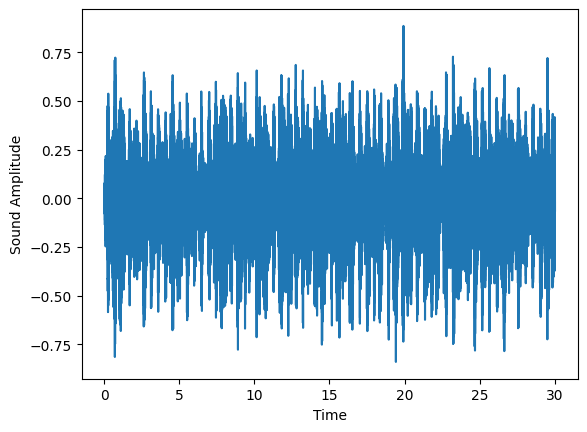

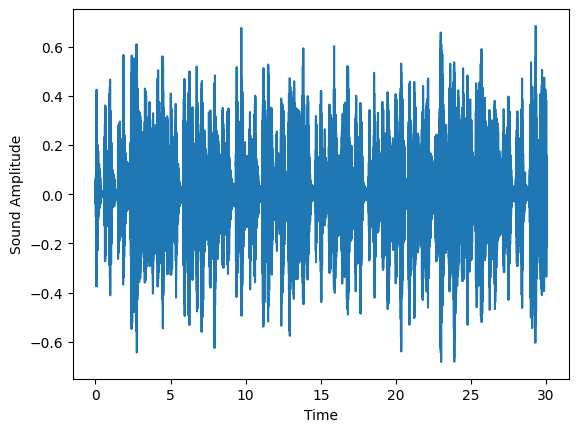

In [ ]:
for i in range(2):
    audio, sfreq = librosa.load(filepath+str(i)+".wav")
    time = np.arange(0, len(audio))/sfreq
    plt.plot(time,audio)
    plt.xlabel("Time")
    plt.ylabel("Sound Amplitude")
    plt.show()

# Clasificador


In [ ]:
import json
import numpy as np

In [ ]:
# load data
def load_data(dataset_path):
    with open(dataset_path,"r") as f:
        data = json.load(f)

    # Convert list to numpy arrays
    inputs = np.array(data["mfcc"])
    targets = np.array(data["labels"])

    return inputs,targets

In [ ]:
inputs,targets = load_data(r"./data.json")

In [ ]:
# splitting the data
from sklearn.model_selection import train_test_split

input_train, input_test, target_train, target_test = train_test_split(inputs, targets, test_size=0.3)
print(input_train.shape, target_train.shape)

(6990, 130, 13) (6990,)


In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import *

In [ ]:
model = Sequential()

model.add(Flatten(input_shape=(inputs.shape[1],inputs.shape[2])))
model.add(Dense(512, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(10, activation='softmax'))
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 1690)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       865,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,014,218 (3.87 MB)

 Trainable params: 1,014,218 (3.87 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras import optimizers
adam = optimizers.Adam(learning_rate=1e-4)

In [ ]:
model.compile(optimizer=adam,
             loss="sparse_categorical_crossentropy",
             metrics=["accuracy"])

In [ ]:
model.compile(optimizer=adam,
             loss="sparse_categorical_crossentropy",
             metrics=["accuracy"])

hist = model.fit(input_train, target_train,
                 validation_data = (input_test,target_test),
                 epochs = 50,
                 batch_size = 32)
clear_output()

In [ ]:
def plot_history(hist):
    plt.figure(figsize=(20,15))
    fig, axs = plt.subplots(2)
    # accuracy subplot
    axs[0].plot(hist.history["accuracy"], label="train accuracy")
    axs[0].plot(hist.history["val_accuracy"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")

    # Error subplot
    axs[1].plot(hist.history["loss"], label="train error")
    axs[1].plot(hist.history["val_loss"], label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")

    plt.show()

<Figure size 2000x1500 with 0 Axes>

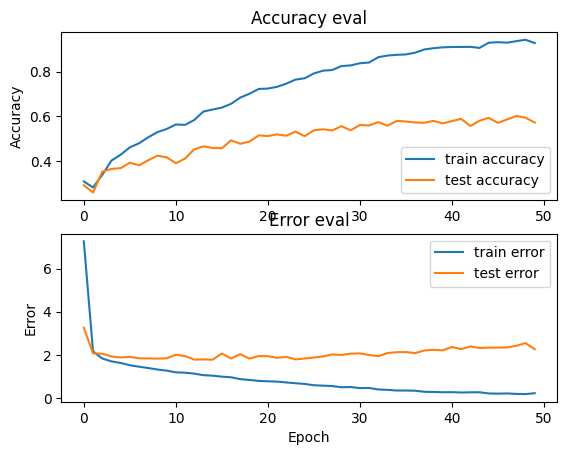

In [ ]:
plot_history(hist)

In [ ]:
test_error, test_accuracy = model.evaluate(input_test, target_test, verbose=1)
print(f"Test accuracy: {test_accuracy}")

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5598 - loss: 2.3340
Test accuracy: 0.5720961093902588


# Overfitting
Para lidiar con el sobreajuste se pueden realizar las siguientes acciones
- Hacer la arquitectura menos compleja
- Usar data aumentada
- Detener prontamente el entrenamiento
- Agregar capas abandonadas
- Regularizacion / Standardizacion  


In [ ]:
import tensorflow.keras as keras

In [ ]:
# Overfitting
model = Sequential()

model.add(Flatten(input_shape=(inputs.shape[1],inputs.shape[2])))
model.add(Dense(512, activation='relu', kernel_regularizer = keras.regularizers.l2(0.001)))
model.add(Dropout(0.3))
model.add(Dense(256, activation='relu', kernel_regularizer = keras.regularizers.l2(0.003)))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu', kernel_regularizer = keras.regularizers.l2(0.01)))
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
model.add(Dense(10, activation='softmax'))
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)             │ (None, 1690)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │       865,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,015,978 (3.88 MB)

 Trainable params: 1,015,978 (3.88 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.optimizers import Adam

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

<Figure size 2000x1500 with 0 Axes>

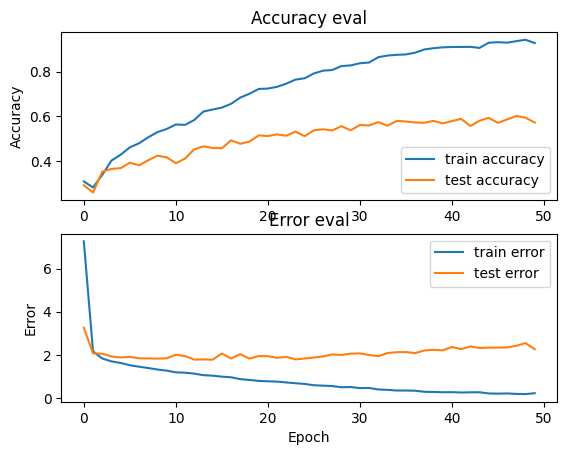

In [ ]:
plot_history(hist)

In [ ]:
test_error, test_accuracy = model.evaluate(input_test, target_test, verbose=1)
print(f"Test accuracy: {test_accuracy}")

 3/94 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.1163 - loss: 77.1209

/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.1175 - loss: 79.2626
Test accuracy: 0.10180240124464035


We can see that the overfitting is greatly reduced but still we are not able to get a good accuracy. Now we will try doing it with Convolutional Neural Network (CNN)

Podemos ver que el sobreajuste es ampliamente reducido, pero no logramos una buena precision. Para lidiar con esto vamos a usar una Red Neuronal Convolucional.

# CNN


In [ ]:
def prepare_dataset(test_size, validation_size):
    X,y = load_data(r"./data.json")

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = validation_size)
    X_train = X_train[..., np.newaxis]
    X_val = X_val[..., np.newaxis]
    X_test = X_test[..., np.newaxis]

    return X_train, X_val, X_test, y_train, y_val, y_test

In [ ]:
X_train, X_val, X_test, y_train, y_val, y_test = prepare_dataset(0.25, 0.2)

In [ ]:
input_shape = (X_train.shape[1],X_train.shape[2],X_train.shape[3])
print(input_shape)

(130, 13, 1)


In [ ]:
model = Sequential()
model.add(Conv2D(64, (3, 3), activation = "relu", input_shape = input_shape))
model.add(MaxPool2D((3, 3), strides=(2, 2), padding="same"))
model.add(BatchNormalization())

model.add(Conv2D(32, (3, 3), activation = "relu"))
model.add(MaxPool2D((3, 3), strides=(2, 2), padding="same"))
model.add(BatchNormalization())

model.add(Conv2D(32, (2, 2), activation = "relu"))
model.add(MaxPool2D((2, 2), strides=(2, 2), padding="same"))
model.add(BatchNormalization())

model.add(Conv2D(16, (1, 1), activation = "relu"))
model.add(MaxPool2D((1, 1), strides=(2, 2), padding="same"))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(10, activation="softmax"))

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 11, 64)    │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 6, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 6, 64)      │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 62, 4, 32)      │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 31, 2, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 31, 2, 32)      │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 30, 1, 32)      │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 15, 1, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 15, 1, 32)      │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 15, 1, 16)      │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 1, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 8, 1, 16)       │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,242 (129.85 KB)

 Trainable params: 32,954 (128.73 KB)

 Non-trainable params: 288 (1.12 KB)

In [ ]:
from tensorflow.keras.optimizers import Adam

# nueva instancia del optimizador
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# entrenamiento
hist = model.fit(X_train, y_train,
                 validation_data=(X_val, y_val),
                 epochs=40,
                 batch_size=32)


Epoch 1/40


/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step - accuracy: 0.1182 - loss: 2.8002

/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


188/188 ━━━━━━━━━━━━━━━━━━━━ 63s 336ms/step - accuracy: 0.1184 - loss: 2.7991 - val_accuracy: 0.2203 - val_loss: 2.1538
Epoch 2/40
188/188 ━━━━━━━━━━━━━━━━━━━━ 83s 344ms/step - accuracy: 0.2321 - loss: 2.2245 - val_accuracy: 0.3364 - val_loss: 1.8686
Epoch 3/40
188/188 ━━━━━━━━━━━━━━━━━━━━ 79s 327ms/step - accuracy: 0.3394 - loss: 1.9306 - val_accuracy: 0.4259 - val_loss: 1.6740
Epoch 4/40
188/188 ━━━━━━━━━━━━━━━━━━━━ 82s 326ms/step - accuracy: 0.3841 - loss: 1.7724 - val_accuracy: 0.4513 - val_loss: 1.5492
Epoch 5/40
188/188 ━━━━━━━━━━━━━━━━━━━━ 80s 316ms/step - accuracy: 0.4286 - loss: 1.6309 - val_accuracy: 0.4866 - val_loss: 1.4576
Epoch 6/40
188/188 ━━━━━━━━━━━━━━━━━━━━ 85s 330ms/step - accuracy: 0.4428 - loss: 1.5777 - val_accuracy: 0.4933 - val_loss: 1.4081
Epoch 7/40
188/188 ━━━━━━━━━━━━━━━━━━━━ 60s 321ms/step - accuracy: 0.4800 - loss: 1.4759 - val_accuracy: 0.5120 - val_loss: 1.3329
Epoch 8/40
188/188 ━━━━━━━━━━━━━━━━━━━━ 62s 328ms/step - accuracy: 0.4936 - loss: 1.4109 - val

<Figure size 2000x1500 with 0 Axes>

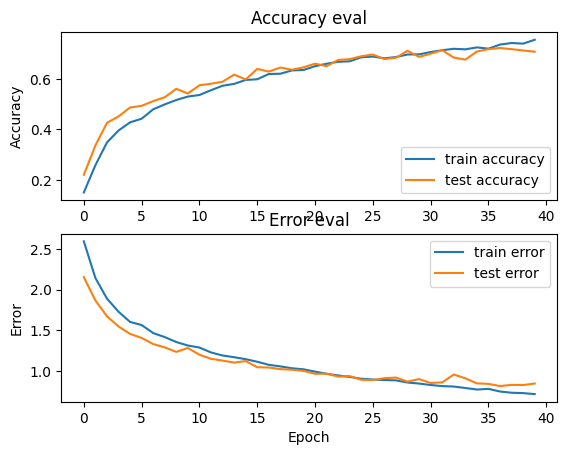

In [ ]:
plot_history(hist)

In [ ]:
test_error, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"Test accuracy: {test_accuracy}")

 1/79 ━━━━━━━━━━━━━━━━━━━━ 7s 91ms/step - accuracy: 0.6562 - loss: 0.8354

/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - accuracy: 0.6924 - loss: 0.8693
Test accuracy: 0.7040448784828186


In [ ]:
def predict(model, X, y):
    X = X[np.newaxis,...]
    prediction = model.predict(X)
    predicted_index = np.argmax(prediction, axis=1)
    print(f"Expected index: {y}, Predicted index: {predicted_index}")

In [ ]:
predict(model, X_test[10], y_test[10])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
Expected index: 2, Predicted index: [2]


/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
